In [1]:
!pip install nltk
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import requests
import csv
import seaborn
import time
import operator
import concurrent.futures
import matplotlib.pyplot as plt
import nltk

from google.colab import files
from itertools import filterfalse, islice
from functools import reduce, lru_cache
from nltk.corpus import stopwords
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
positive_words = pd.read_csv('InSet_pos.tsv', header=None, delimiter='\t')
negative_words = pd.read_csv('InSet_neg.tsv', header=None, delimiter='\t')

In [6]:
# Function to preprocess text
def preprocess_text(text):
    words = word_tokenize(text.lower())
    return words

# Function to calculate sentiment score
def sentiment_score(words):
    score = 0
    for word in words:
        if word in positive_words.values:
            score += 1
        elif word in negative_words.values:
            score -= 1
    return score

# Function to classify sentiment
def classify_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

# Function to extract text from URL
def extract_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = ' '.join([p.text for p in soup.find_all('p')])
    return text

sentiment_counts = {'neutral': 0, 'positive': 0, 'negative': 0}

In [23]:
urls = [
    'https://www.cnnindonesia.com/olahraga/20230612061855-142-960496/memahat-megarekor-timnas-indonesia-dan-anti-inferior-argentina/amp',
    'https://www.bolasport.com/amp/read/313809587/timnas-argentina-bakal-mainkan-skuad-pelapis-saat-hadapi-timnas-indonesia-sinyal-lionel-messi-tak-datang-menguat',
    'https://www.bola.net/amp/tim_nasional/loh-loh-loh-lionel-messi-batal-ikut-rombongan-timnas-argentina-ke-indonesia-7a6258.html',
    'https://www.cnnindonesia.com/olahraga/20230612081940-142-960518/reaksi-netizen-soal-isu-argentina-akan-rotasi-pemain-lawan-indonesia/amp',
    'https://mamagini.suara.com/amp/read/2023/06/09/142338/cek-fakta-tolak-argentina-main-dengan-indonesia-anies-baswedan-dipermalukan-di-depan-publik',
    'https://www.kompas.tv/amp/video/415279/laga-vs-palestina-dan-argentina-sebentar-lagi-timnas-indonesia-berlatih-perkuat-fisik',
    'https://www.sportstars.id/amp/malaysia-soroti-penjualan-tiket-timnas-indonesia-vs-argentina-yang-ludes-hitungan-menit-3wSZ83',
    'https://inet.detik.com/cyberlife/d-6767375/laga-indonesia-vs-argentina-tanpa-messi-ibarat-sayur-tanpa-garam-hambar/amp',
    'https://www.antvklik.com/amp/olahraga/591156-kecewa-timnas-argentina-disebut-bakal-turunkan-skuad-lapis-kedua-lawan-indonesia',
    'https://bola.okezone.com/amp/2023/06/12/51/2829119/media-argentina-sebut-penyebab-lionel-messi-absen-di-laga-timnas-indonesia-vs-argentina',
    'https://www.cnbcindonesia.com/news/20230611151017-4-444922/isu-messi-batal-datang-warganet-jual-tiket-ri-argentina/amp',
    'https://www.bola.net/amp/tim_nasional/duh-usai-messi-disebut-bakal-absen-kini-timnas-argentina-dikabarkan-akan-lakukan-rotasi-pemai-202511.html',
    'https://deli.suara.com/amp/read/2023/06/12/084438/kabar-buruk-lionel-messi-ogah-lawan-timnas-indonesia-argentina-turunkan-pelapis',
    'https://www.bolasport.com/amp/read/313809732/tidak-ikut-skuad-argentina-lionel-messi-pilih-liburan-ketimbang-lawan-timnas-indonesia',
    'https://palembang.tribunnews.com/amp/2023/06/12/sinyal-lionel-messi-tidak-main-lawan-timnas-indonesia-kian-menguat-argentina-turunkan-skuad-pelapis',
    'https://www.bolanusantara.com/timnas/amp/5539107637/julian-alvarez-siap-gantikan-sosok-lionel-messi-saat-argentina-tantang-timnas-indonesia',
    'https://bola.okezone.com/amp/2023/06/11/51/2828952/penyebab-timnas-argentina-dikabarkan-bakal-turunkan-pemain-pelapis-lawan-timnas-indonesia',
    'https://jakarta.tribunnews.com/amp/2023/06/12/viral-argentina-bakal-pakai-pemain-lapis-kedua-lawan-timnas-indonesia-asnawi-gagal-tekel-messi',
    'https://www.bola.com/amp/5316267/harapan-agar-lionel-messi-ikut-rombongan-timnas-argentina-ke-indonesia-dan-berkunjung-ke-bali',
    'https://www.suara.com/video/2023/06/12/070000/jelang-lawan-timnas-indonesia-pelatih-argentina-bilang-begini',
    'https://www.bolanusantara.com/timnas/amp/5539104691/waduh-timnas-argentina-dikabarkan-tidak-menurunkan-skuat-piala-dunia-2022-saat-melawan-indonesia',
    'https://bola.okezone.com/amp/2023/06/11/51/2828853/perempuan-cantik-kamboja-batal-nonton-laga-timnas-indonesia-vs-argentina-saya-sangat-menyesal',
    'https://garut.suara.com/amp/read/2023/06/12/060000/jelang-laga-indonesia-vs-argentina-komentar-kocak-bermunculan-netizen-kapan-lagi-ngeliat-indonesia-bantai-juara-piala-dunia',
    'https://www.cnnindonesia.com/olahraga/20230609114745-142-959715/pemain-timnas-indonesia-belum-kumpul-persiapan-argentina-mepet/amp',
    'https://m.kumparan.com/amp/kumparanbola/timnas-argentina-diklaim-kantongi-rp-96-7-m-dari-lawan-indonesia-and-australia-20a3hSfJlsN',
    'https://www.harianhaluan.com/sport/amp/109106573/argentina-hanya-siapkan-tim-pelapis-messi-ke-indonesia-cuma-prank-aja',
    'https://www.cnnindonesia.com/olahraga/20230609075955-142-959606/pesan-emosional-elkan-baggott-jelang-indonesia-vs-argentina/amp',
    'https://www.batastimor.com/nasional/amp/8059108839/fifa-match-day-indonesia-vs-argentina-didukung-bri-perputaran-ekonomi-berpotensi-naik',
    'https://www.radardepok.com/metropolis/amp/9469106227/yakin-timnas-indonesia-menang-lawan-argentina-ini-prediksi-bos-persikad-1999',
    'https://www.sportstars.id/amp/kabar-buruk-lionel-messi-dikabarkan-batal-perkuat-timnas-argentina-ke-indonesia-pada-fifa-matchday-lLJ444',
    'https://www.kompasiana.com/amp/ilhamfaisal/648655224d498a461903b064/jika-messi-dan-bintang-absen-di-gbk-mungkin-argentina-sudah-pelajari-indonesia',
    'https://www.bolanusantara.com/timnas/amp/5539105508/reaksi-netizen-indonesia-saat-tahu-argentina-turunkan-tim-lapis-kedua-waktunya-kita-bantai-mereka',
    'https://m.jpnn.com/amp/news/dukung-laga-timnas-indonesia-vs-argentina-ratusan-warga-ternate-melakukan-ini',
    'https://www.genpi.co/amp/sport/221477/jelang-lawan-palestina-dan-argentina-timnas-indonesia-dapat-motivasi-mental',
    'https://kalteng.tribunnews.com/amp/2023/06/11/sandy-walsh-gagal-debut-di-laga-timnas-indonesia-vs-argentina-janjikan-ini-kepada-supporter',
    'https://manado.tribunnews.com/amp/2023/06/12/kabar-terkini-soal-fifa-matchday-argentina-disebut-turunkan-pemain-pelapis-saat-melawan-indonesia',
    'https://www.bolanusantara.com/timnas/amp/5539103669/inikah-2-faktor-penyebab-bintang-argentina-lionel-messi-batal-ke-indonesia',
    'https://www.bola.com/indonesia/read/5314682/timnas-indonesia-vs-argentina-ipswich-town-ulas-kemungkinan-elkan-baggott-menghadapi-lionel-messi',
    'https://bandung.suara.com/read/2023/06/12/060000/lionel-messi-diisukan-batal-datang-bersama-timnas-argentina-ke-indonesia-netizen-calo-ketar-ketir',
    'https://linimasa.suara.com/read/2023/06/11/200823/lionel-messi-dikabarkan-batal-ke-indonesia-perkuat-timnas-argentina-ketahui-penyebabnya',
    'https://www.bolasport.com/read/313809049/messi-batal-main-di-indonesia-5-pemain-argentina-ini-tetap-seru-untuk-ditonton',
    'https://www.cnnindonesia.com/olahraga/20230612022108-142-960481/lawan-indonesia-argentina-disebut-bakal-simpan-pemain-bintang',
    'https://sport.detik.com/sepakbola/liga-indonesia/d-6767028/indonesia-vs-argentina-ini-yang-bakal-dilakukan-elkan-baggott',
    'https://www.kompas.com/sports/read/2023/06/11/06213228/timnas-indonesia-vs-argentina-messi-masuk-skuad-disebut-tak-ikut-rombongan',
    # 'https://amp.kompas.com/bola/read/2023/06/12/05200058/fifa-matchday-indonesia-vs-palestina-argentina-misi-pribadi-dendy'
    # 'https://www.cnbcindonesia.com/news/20230611151017-4-444922/isu-messi-batal-datang-warganet-jual-tiket-ri-argentina',
    'https://www.bola.net/tim_nasional/timnas-indonesia-vs-argentina-info-jadwal-pertandingan-stadion-harga-tiket-dan-siaran-langsun-07ac63.html',
    'https://ntt.pikiran-rakyat.com/olahraga/pr-2326769237/lionel-messi-batal-datang-netizen-ramai-over-tiket-indonesia-vs-argentina',
    'https://www.libero.id/detail/25224/catat-jadwal-siaran-langsung-timnas-indonesia-vs-timnas-argentina-1-1.html',
    'https://www.floreseditorial.com/news/3979108733/di-dukung-bri-potensi-perputaran-ekonomi-fifa-match-day-indonesia-vs-argentina-diproyeksi-tembus-rp500-miliar',
    'https://wow.tribunnews.com/2023/06/11/live-streaming-timnas-indonesia-vs-argentina-lionel-messi-tak-main-scaloni-akan-turunkan-pelapis',
    'https://www.viva.co.id/bola/bola-sejagat/1608212-fantastis-segini-uang-yang-diterima-argentina-dari-tur-china-dan-indonesia',
    'https://www.sportstars.id/read/simak-jadwal-dan-panduan-penukaran-tiket-timnas-indonesia-vs-argentina-E83VN4',
    'https://nasional.okezone.com/read/2023/06/11/337/2828949/effendi-syahputra-sarankan-erick-thohir-lobi-argentina-ajak-messi-terbang-ke-indonesia',
    'https://bolaskor.com/post/read/argentina-bakal-turunkan-susunan-pemain-berbeda-kontra-australia-dan-indonesia',
    'https://mamagini.suara.com/read/2023/06/11/182713/cek-fakta-tolak-pertandingan-argentina-vs-indonesia-anies-baswedan-berakhir-dipermalukan-erick-thohir-benarkah',
    'https://www.cnnindonesia.com/olahraga/20230611004047-142-960208/sumardji-masih-berharap-sandy-walsh-main-di-indonesia-vs-argentina',
    'https://cianjur.suara.com/read/2023/06/12/083000/argentina-turunkan-tim-pelapis-dalam-fifa-matchday-lawan-indonesia-netizen-geram',
    'https://www.harianhaluan.com/news/109106000/makin-kacau-pelatih-argentina-dikabarkan-bakal-turunkan-tim-lapis-2-untuk-lawan-timnas-indonesia',
    'https://www.cnnindonesia.com/olahraga/20230607140625-142-958778/skuad-argentina-bakal-pincang-lawan-timnas-indonesia',
    'https://www.cnnindonesia.com/olahraga/20230606121125-142-958178/ludes-2-menit-tiket-indonesia-vs-argentina-sold-out-di-hari-kedua/amp',
    'https://fajar.co.id/2023/06/11/ramai-jual-lagi-tiket-indonesia-vs-argentina-karena-messi-batal-hadir-pengamat-sangat-menurunkan-atensi-para-penonton/',
    'https://www.kompas.tv/olahraga/415215/lionel-messi-disebut-tak-tampil-saat-indonesia-vs-argentina-refund-sempat-trending-di-twitter',
    'https://www.harianhaluan.com/sport/109106261/ada-sosok-shin-tae-yong-ketum-federasi-sepak-bola-argentina-ogah-remehkan-timnas-indonesia',
    'https://bola.tempo.co/amp/1736060/calon-penonton-timnas-indonesia-vs-argentina-siap-jual-tiketnya-jika-lionel-messi-tak-datang',
    'https://www.cnnindonesia.com/olahraga/20230609094055-142-959639/2-persiapan-utama-sty-untuk-pemain-indonesia-lawan-argentina',
    'https://tidore.pikiran-rakyat.com/daerah/pr-3006768071/dukung-pertandingan-indonesia-vs-argentina-ratusan-warga-di-ternate-maluku-utara-gelar-jalan-pagi-dan-zumba',
    'https://www.harianhaluan.com/sport/109105476/bonus-juara-sea-games-2023-ernando-ari-didapuk-jadi-kiper-timnas-indonesia-saat-lawan-argentina',
    'https://www.cnbcindonesia.com/lifestyle/20230606094900-33-443294/tiket-indonesia-vs-argentina-masih-ada-banyak-buka-jam-11',
    'https://inet.detik.com/cyberlife/d-6766873/harap-harap-cemas-netizen-jika-lionel-messi-gagal-ke-indonesia',
    'https://curupekspress.disway.id/read/650546/messi-batal-ke-indonesia-ini-ciutan-jurnalis-argentina',
    'https://voi.id/olahraga/286103/rumor-lionel-messi-batal-ke-indonesia-pssi-kami-menunggu-keterangan-resmi-federasi-sepak-bola-argentina',
    'https://makassar.tribunnews.com/2023/06/11/bernardo-tavares-doakan-indonesia-menang-lawan-argentina-dan-palestina',
    'https://www.cnnindonesia.com/olahraga/20230609084509-142-959618/lingard-pemain-indonesia-jangan-terpukau-dengan-argentina',
    'https://www.sportstars.id/amp/beda-dengan-sty-sumardji-sebut-sandy-walsh-masih-berpeluang-perkuat-timnas-indonesia-vs-argentina-7H64Rg#amp_tf=From%20%251%24s&aoh=16865403862709&referrer=https%3A%2F%2Fwww.google.com'
]

article_data = []

for url in urls:
    text = extract_text(url)
    words = preprocess_text(text)
    score = sentiment_score(words)
    sentiment = classify_sentiment(score)
    sentiment_counts[sentiment] += 1
    article_data.append({'Sumber':url,'sentiment': sentiment, 'text': text})  # Append the sentiment and text to the list
    print(f'URL: {url}')
    print('Sentiment score:', score)
    print('Sentiment:', sentiment)
    print('---')

URL: https://www.cnnindonesia.com/olahraga/20230612061855-142-960496/memahat-megarekor-timnas-indonesia-dan-anti-inferior-argentina/amp
Sentiment score: -15
Sentiment: negative
---
URL: https://www.bolasport.com/amp/read/313809587/timnas-argentina-bakal-mainkan-skuad-pelapis-saat-hadapi-timnas-indonesia-sinyal-lionel-messi-tak-datang-menguat
Sentiment score: -6
Sentiment: negative
---
URL: https://www.bola.net/amp/tim_nasional/loh-loh-loh-lionel-messi-batal-ikut-rombongan-timnas-argentina-ke-indonesia-7a6258.html
Sentiment score: 12
Sentiment: positive
---
URL: https://www.cnnindonesia.com/olahraga/20230612081940-142-960518/reaksi-netizen-soal-isu-argentina-akan-rotasi-pemain-lawan-indonesia/amp
Sentiment score: 2
Sentiment: positive
---
URL: https://mamagini.suara.com/amp/read/2023/06/09/142338/cek-fakta-tolak-argentina-main-dengan-indonesia-anies-baswedan-dipermalukan-di-depan-publik
Sentiment score: -13
Sentiment: negative
---
URL: https://www.kompas.tv/amp/video/415279/laga-vs-pale

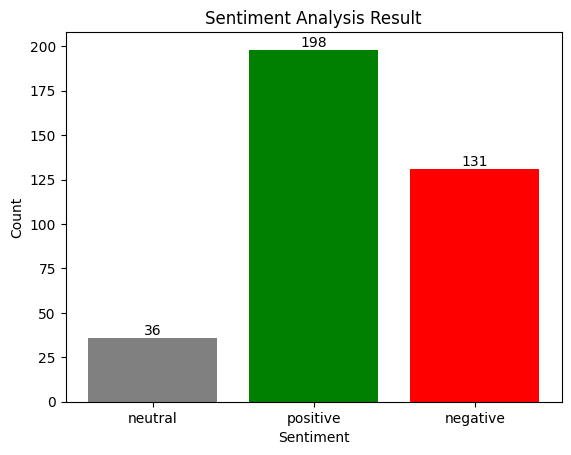

In [24]:
# Create the bar graph
bars = plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['gray', 'green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis Result')

# Add labels to the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(bar.get_height()), ha='center', va='bottom')

plt.show()

In [25]:
# Create a DataFrame from the article_data list
articles_df = pd.DataFrame(article_data)

# Separate the articles by sentiment
positive_articles_df = articles_df[articles_df['sentiment'] == 'positive']
negative_articles_df = articles_df[articles_df['sentiment'] == 'negative']
neutral_articles_df = articles_df[articles_df['sentiment'] == 'neutral']

# Save the DataFrames to separate CSV files
positive_articles_df.to_csv('positive_articles.csv', index=False)
negative_articles_df.to_csv('negative_articles.csv', index=False)
neutral_articles_df.to_csv('neutral_articles.csv', index=False)

In [26]:
#Download the csv files

files.download('positive_articles.csv')
files.download('negative_articles.csv')
files.download('neutral_articles.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>